In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
% matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#ETF natural gas
ticker = 'UNG'
volume = yf.download(tickers=ticker, start='2021-01-01', end=None, interval="1d", group_by='column', auto_adjust=True,
                     prepost=True, threads=True, proxy=None)['Volume']


def days_liquidation(quantity, volume, window, fraction):
    avg_vol_fraction = volume.rolling(window).mean() * fraction
    return round(quantity / avg_vol_fraction, 2)


quantity = 100000
window = 63
fraction = 0.01
days_liquidation(quantity, volume, window, fraction)[-1]

[*********************100%***********************]  1 of 1 completed


0.53

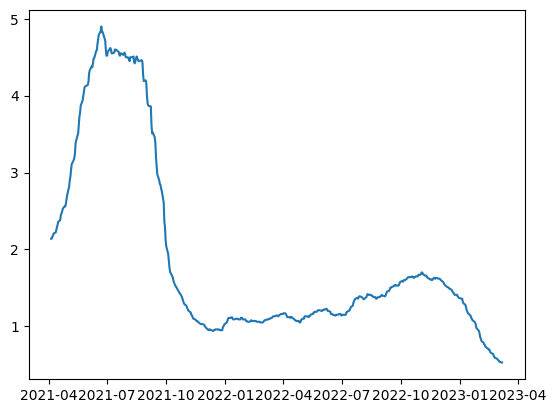

In [3]:
plt.plot(days_liquidation(quantity, volume, window, fraction))

In [4]:
K = 1000000
lot = 100
port_tickers = ['QCOM', 'TSLA', 'NFLX', 'DIS', 'PG', 'MMM', 'IBM', 'BRK-B', 'UPS', 'F']
bm_ticker = '^GSPC'
tickers_list = [bm_ticker] + port_tickers
df_data = {
    'Beta': [1.34, 2, 0.75, 1.2, 0.41, 0.95, 1.23, 0.9, 1.05, 1.15],
    'Shares': [-1900, -100, -400, -800, -5500, 1600, 1800, 2800, 1100, 20800],
    'rSL': [42.75, 231, 156, 54.2, 37.5, 42.75, 29.97, 59.97, 39.97, 2.10]
}
port = pd.DataFrame(df_data, index=port_tickers)
port['Side'] = np.sign(port['Shares'])

start_dt = '2021-01-01'
end_dt = '2021-07-01'
price_df = round(yf.download(tickers=tickers_list, start='2021-01-01',
                             end='2021-07-01', interval="1d", group_by='column', auto_adjust=True, prepost=True,
                             threads=True, proxy=None)['Close'], 2)

bm_cost = price_df[bm_ticker][0]
bm_price = price_df[bm_ticker][-1]

port['rCost'] = round(price_df.iloc[0, :].div(bm_cost) * 1000, 2)
port['rPrice'] = round(price_df.iloc[-1, :].div(bm_price) * 1000, 2)
port['Cost'] = price_df.iloc[0, :]
port['Price'] = price_df.iloc[-1, :]

[*********************100%***********************]  11 of 11 completed


In [5]:
price_df['bm returns'] = round(np.exp(np.log(price_df[bm_ticker]/price_df[bm_ticker].shift()).cumsum()) - 1, 3)
rel_price = round(price_df.div(price_df['^GSPC'],axis=0 )*1000,2)

rMV = rel_price.mul(port['Shares'])
rLong_MV = rMV[rMV >0].sum(axis=1)
rShort_MV = rMV[rMV <0].sum(axis=1)
rMV_Beta = rMV.mul(port['Beta'])
rLong_MV_Beta = rMV_Beta[rMV_Beta >0].sum(axis=1) / rLong_MV
rShort_MV_Beta = rMV_Beta[rMV_Beta <0].sum(axis=1)/ rShort_MV

price_df['rNet_Beta'] = rLong_MV_Beta - rShort_MV_Beta
price_df['rNet'] = round((rLong_MV + rShort_MV).div(abs(rMV).sum(axis=1)),3)

price_df['rReturns_Long'] = round(np.exp(np.log(rLong_MV/rLong_MV.shift()).cumsum())-1,3)
price_df['rReturns_Short'] = - round(np.exp(np.log(rShort_MV/rShort_MV.shift()).cumsum())-1,3)
price_df['rReturns'] = price_df['rReturns_Long'] + price_df['rReturns_Short']

MV = price_df.mul(port['Shares'])
Long_MV = MV[MV >0].sum(axis=1)
Short_MV = MV[MV <0].sum(axis=1)
price_df['Gross'] = round((Long_MV - Short_MV).div(K),3)
price_df['Net'] = round((Long_MV + Short_MV).div(abs(MV).sum(axis=1)),3)

price_df['Returns_Long'] = round(np.exp(np.log(Long_MV/Long_MV.shift()).cumsum())-1,3)
price_df['Returns_Short'] = - round(np.exp(np.log(Short_MV/Short_MV.shift()).cumsum())-1,3)
price_df['Returns'] = price_df['Returns_Long'] + price_df['Returns_Short']

MV_Beta = MV.mul(port['Beta'])
Long_MV_Beta = MV_Beta[MV_Beta >0].sum(axis=1) / Long_MV
Short_MV_Beta = MV_Beta[MV_Beta <0].sum(axis=1)/ Short_MV
price_df['Net_Beta'] = Long_MV_Beta - Short_MV_Beta


<Axes: title={'center': 'Returns: benchmark, Long / Short absolute & relative'}, xlabel='Date'>

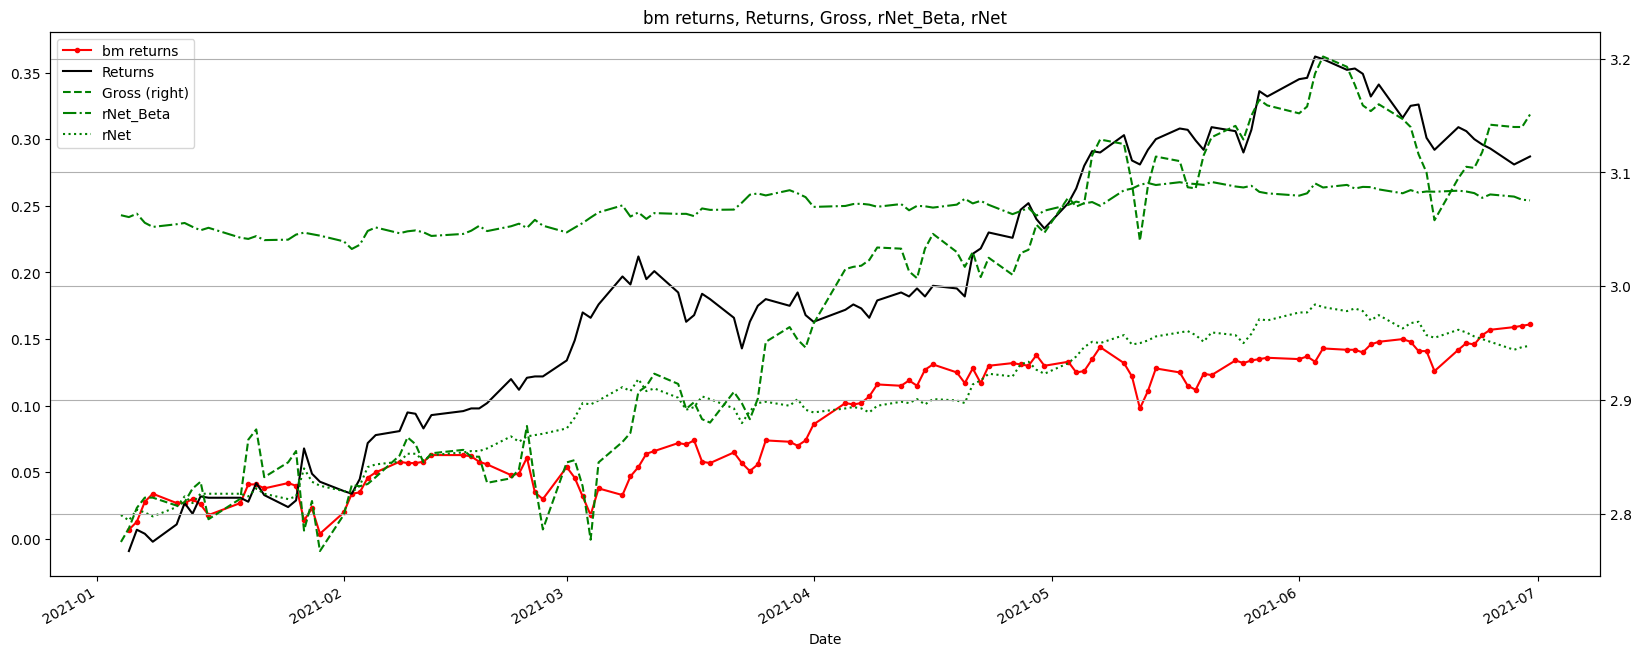

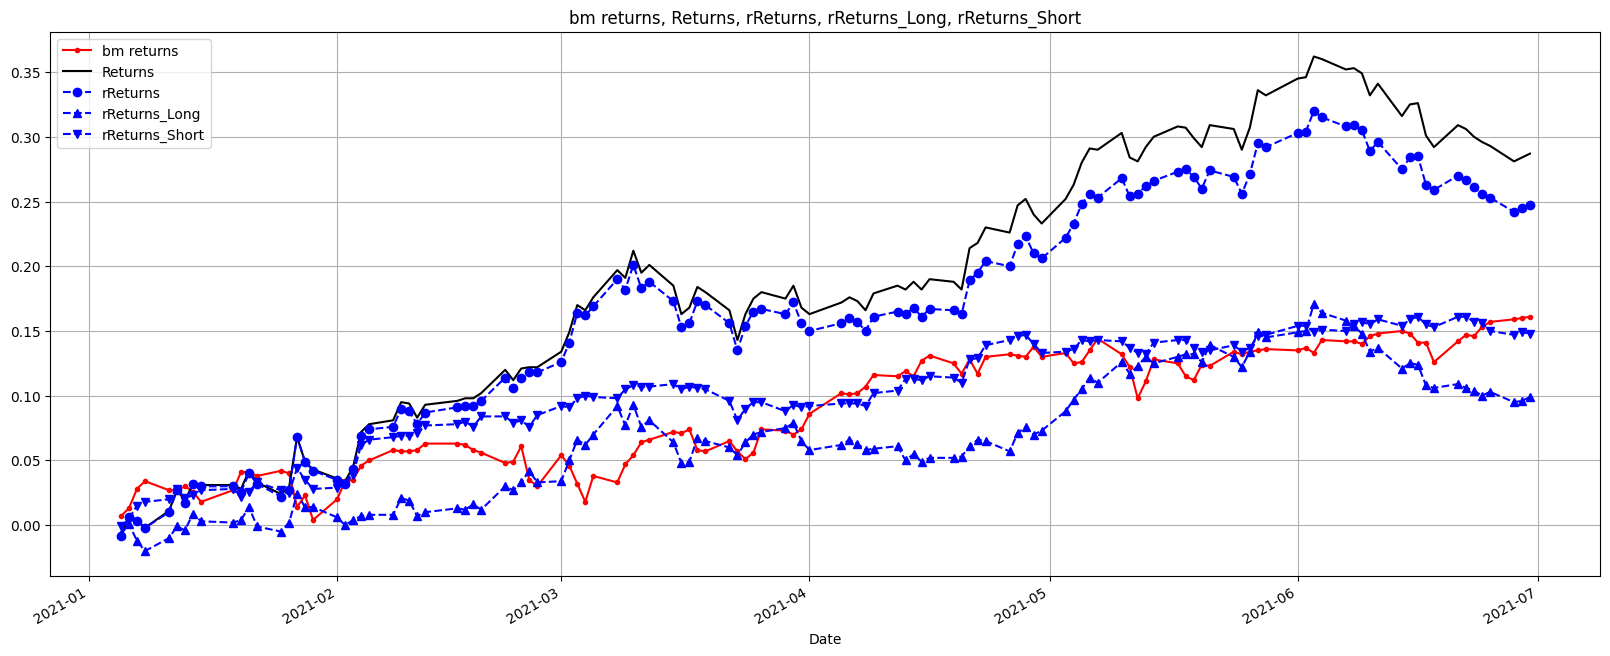

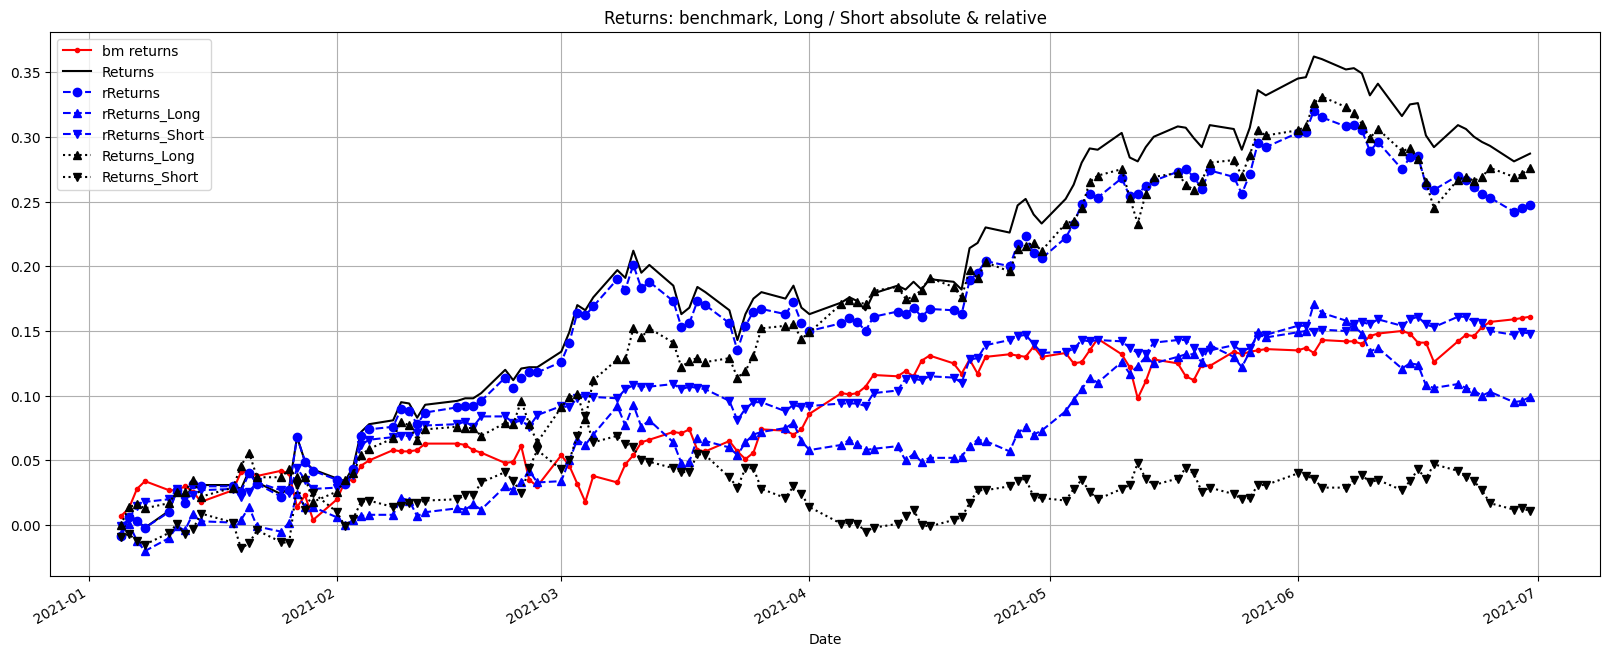

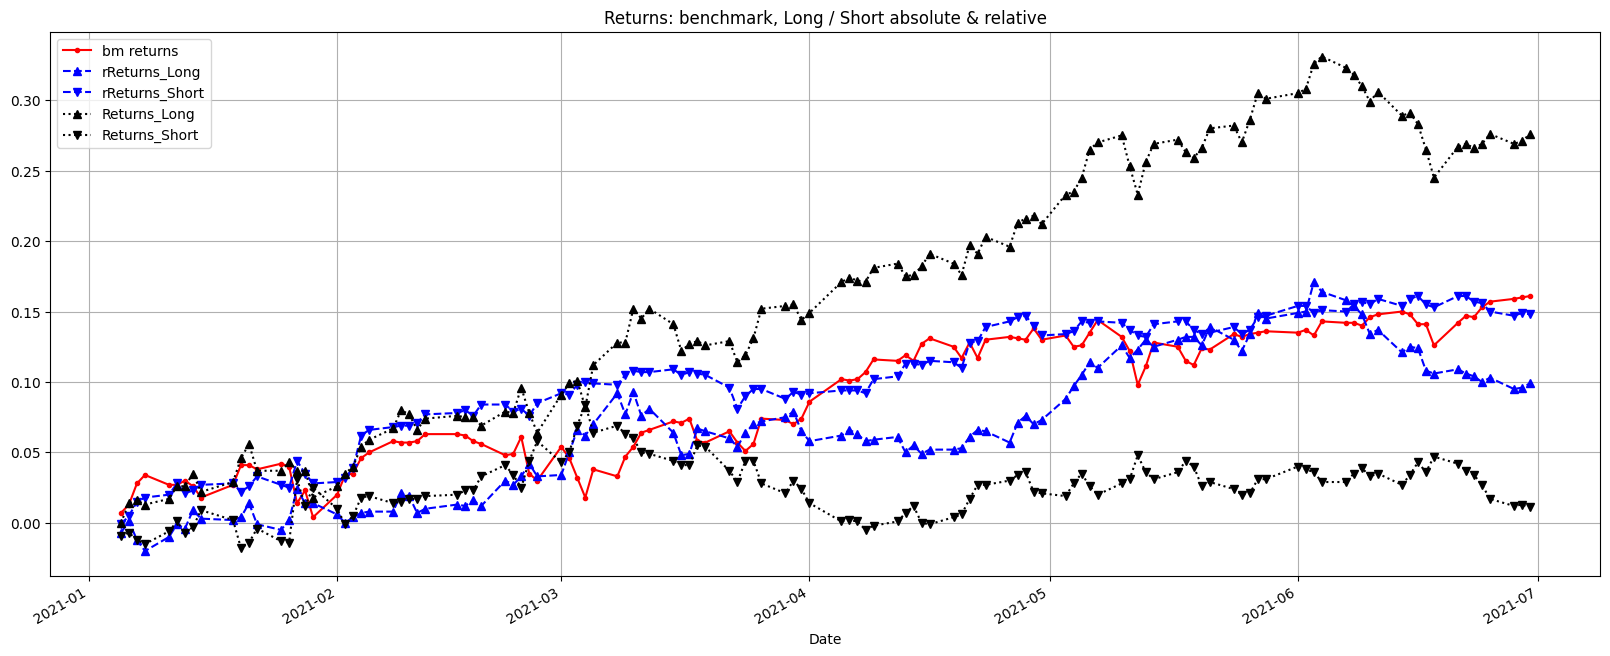

In [6]:
price_df[['bm returns','Returns','Gross','rNet_Beta','rNet' ]].plot(
    figsize=(20,8),grid=True, secondary_y=['Gross'],
    style= ['r.-','k','g--','g-.','g:','b:','c','c:'],
    title = 'bm returns, Returns, Gross, rNet_Beta, rNet')

price_df[['bm returns', 'Returns', 'rReturns', 'rReturns_Long',
          'rReturns_Short']].plot(figsize=(20,8),grid=True,
                                  style= ['r.-','k','b--o','b--^','b--v','g-.','g:','b:'],
                                  title= 'bm returns, Returns, rReturns, rReturns_Long, rReturns_Short')
price_df[['bm returns','Returns','rReturns',
          'rReturns_Long','rReturns_Short','Returns_Long',          'Returns_Short']].plot(
    figsize=(20,8),grid=True,secondary_y=['Gross'],
    style= ['r.-','k','b--o','b--^','b--v','k:^','k:v',],
    title= 'Returns: benchmark, Long / Short absolute & relative')
price_df[['bm returns',
          'rReturns_Long','rReturns_Short','Returns_Long',          'Returns_Short']].plot(
    figsize=(20,8),grid=True,secondary_y=['Gross'],
    style= ['r.-','b--^','b--v','k:^','k:v',],
    title= 'Returns: benchmark, Long / Short absolute & relative')


In [8]:
# Chapter 13: Portfolio Management System
adjust_long = adjust_short  =  -0.01

MV = port['Shares'] * port['Price']
port['Weight'] = round(MV.div(abs(MV).sum()), 3)
port['rR'] = (port['rCost'] - port['rSL'])
port['rRisk'] = -round(np.maximum(0,(port['rR'] * port['Shares'])/K), 4)
port['rRAR'] = round( (port['rPrice'] - port['rCost'])/port['rR'], 1)
port['rCTR'] = round(port['Shares'] * (port['rPrice']-port['rCost'])/ K,4)
port['CTR'] = round(port['Shares'] * (port['Price']-port['Cost'])/ K,4)
port_long = port[port['Side'] > 0]
port_short = port[port['Side'] < 0]
pro_rata_long = port_long['rRisk'] / (port_long['rRisk'].sum() * port_long['rRAR'])
risk_adj_long = (abs(adjust_long) * pro_rata_long * K / port_long['rR'] // lot) * lot
shares_adj_long =  np.minimum(risk_adj_long, port_long['Shares'])*np.sign(adjust_long)

pro_rata_short = port_short['rRisk'] / (port_short['rRisk'].sum() * port_short['rRAR'])
risk_adj_short = (abs(adjust_short) * pro_rata_short * K / port_short['rR'] // lot)*lot
shares_adj_short = np.maximum(risk_adj_short,port_short['Shares'])*np.sign(adjust_short)

port['Qty_adj'] = shares_adj_short.append(shares_adj_long)
port['Shares_adj'] = port['Shares'] + port['Qty_adj']
port['rRisk_adj'] = -round(np.maximum(0,(port['rR'] * port['Shares_adj'])/K),4)
MV_adj= port['Shares_adj'] * port['Price']
rMV_adj = port['Shares_adj'] * port['rPrice']
port['Weight_adj'] = round(MV_adj.div(abs(MV_adj).sum()),3)
port.loc[port['Shares_adj'] != 0,'Shares_adj']

/var/folders/21/rvw9mkxn5jz8cstyz4tllyhr0000gn/T/ipykernel_5252/2358616249.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  port['Qty_adj'] = shares_adj_short.append(shares_adj_long)


QCOM     -1600.0
NFLX      -300.0
DIS       -600.0
PG       -5000.0
MMM       1600.0
IBM       1800.0
BRK-B      400.0
UPS        500.0
F        20800.0
Name: Shares_adj, dtype: float64

In [12]:
port = port.sort_values(by=['Side','rRAR'])
port_cols = ['Side','Beta','Shares_adj','Weight',             'Weight_adj','CTR','rCTR',
             'rRAR','rRisk','rRisk_adj']
port[port_cols]

perf_cols= ['rCTR', 'CTR','rRisk', 'rRisk_adj','rRAR']
desc_cols= ['Side','Beta','Weight','Weight_adj',]
sort_cols = ['Side','rRAR']
asc = [True,True]
port[port_cols].sort_values(by = sort_cols,ascending= asc).style.background_gradient(
    subset = desc_cols, cmap = 'viridis_r').background_gradient(
    subset = perf_cols, cmap = 'RdYlGn').format('{:.5g}')

,Side,Beta,Shares_adj,Weight,Weight_adj,CTR,rCTR,rRAR,rRisk,rRisk_adj
TSLA,-1,2,0,-0.007,0,0.0017,0.0013,0.1,-0.0165,-0
DIS,-1,1.2,-600,-0.045,-0.049,0.0015,0.0057,1.1,-0.005,-0.0037
NFLX,-1,0.75,-300,-0.067,-0.074,-0.0021,0.0074,1.2,-0.0059,-0.0044
QCOM,-1,1.34,-1600,-0.083,-0.103,0.0075,0.0119,1.4,-0.0084,-0.0071
PG,-1,0.41,-5000,-0.226,-0.301,0.0063,0.0284,2.3,-0.0125,-0.0114
F,1,1.15,20800,0.089,0.13,0.1196,0.0216,-104,-0,-0
MMM,1,0.95,1600,0.094,0.138,0.0439,0.0007,-3.5,-0,-0
IBM,1,1.23,1800,0.074,0.108,0.0405,0.0022,-1,-0,-0
BRK-B,1,0.9,400,0.247,0.052,0.1385,0.0082,1.7,-0.0049,-0.0007
UPS,1,1.05,500,0.069,0.046,0.048,0.0048,2.7,-0.0018,-0.0008


<Axes: title={'center': "PORT, by ['Side', 'rRisk_adj']"}>

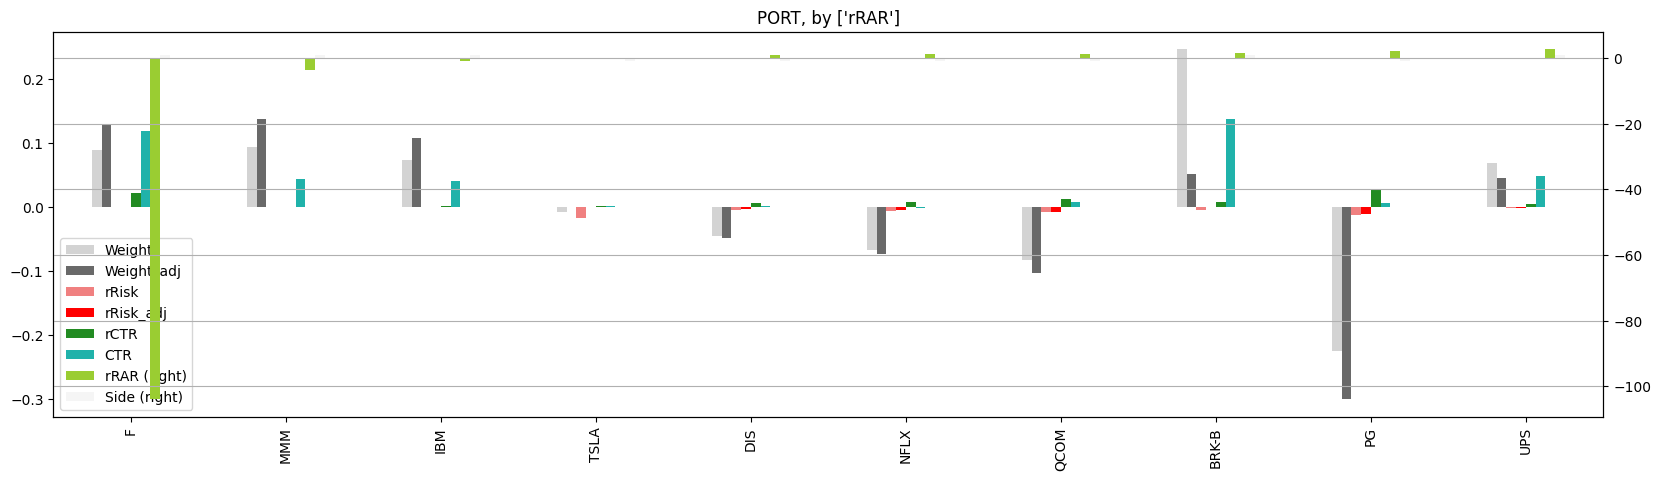

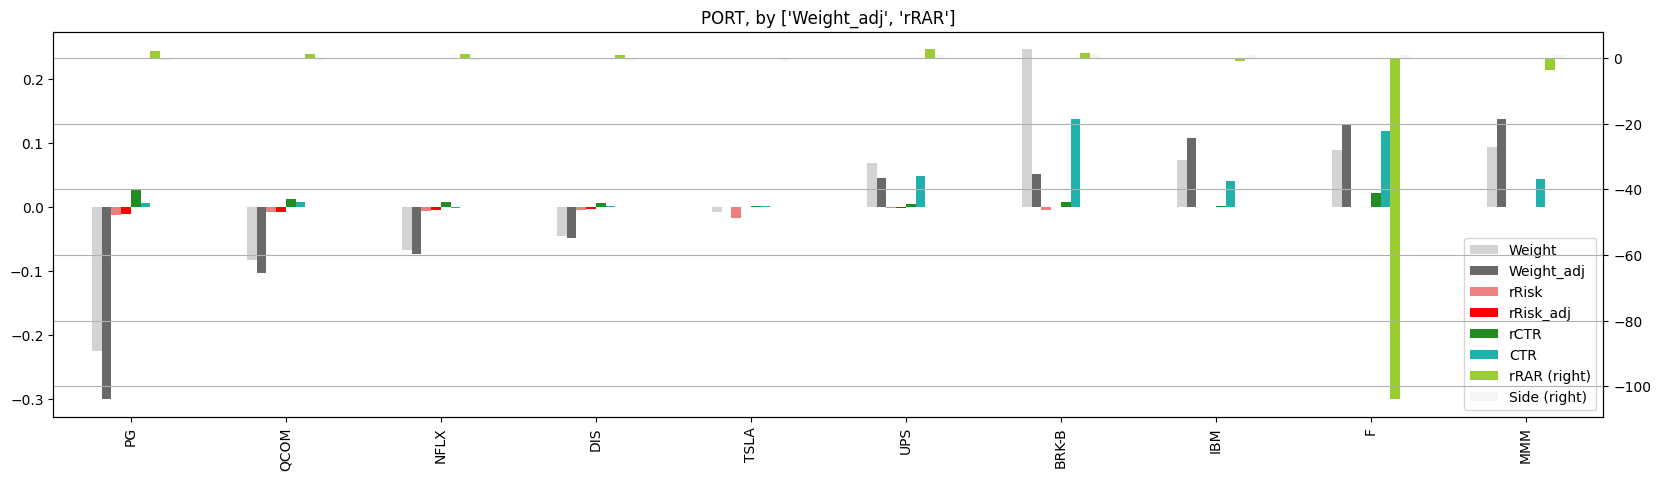

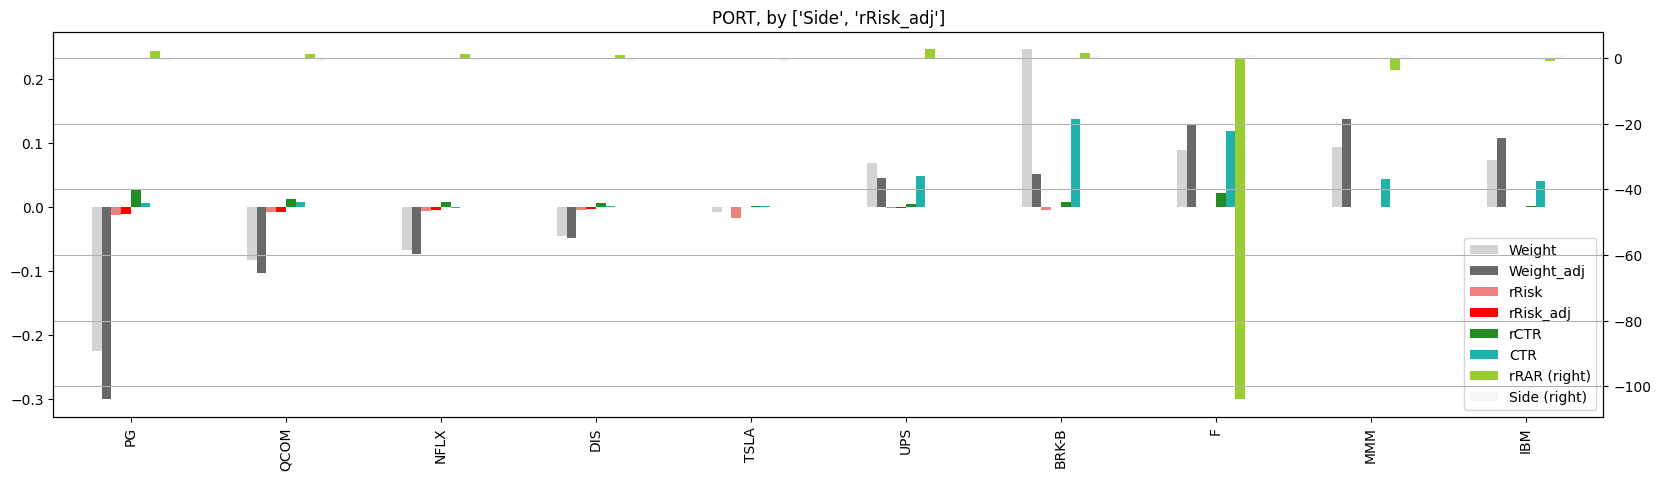

In [13]:
bar_cols= ['Weight', 'Weight_adj','rRisk','rRisk_adj','rCTR',            'CTR','rRAR','Side']
col_style= ['lightgrey','dimgrey','lightcoral','red',
            'forestgreen','lightseagreen','yellowgreen','whitesmoke']
sort_keys= ['Weight_adj','rCTR']
sec_y=['rRAR','Side']
sort= ['rRAR']
port[bar_cols].sort_values(by=sort).plot(kind='bar',
                                         grid=True,figsize=(20,5),
                                         secondary_y=sec_y,color=col_style, title= 'PORT, by '+str(sort))

sort= ['Weight_adj','rRAR']
port[bar_cols].sort_values(by=sort).plot(kind='bar',
                                         grid=True,figsize=(20,5),
                                         secondary_y=sec_y,color=col_style, title= 'PORT, by '+str(sort))

sort= ['Side','rRisk_adj']
port[bar_cols].sort_values(by=sort).plot(kind='bar',
                                         grid=True,figsize=(20,5),
                                         secondary_y=sec_y,color=col_style, title= 'PORT, by '+str(sort))